In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import warnings

#make plots a little bigger because they are too small
plt.rcParams['figure.figsize'] = [8, 8]

#this is because the way my acceleration function works causes an div by 0 warning, and it was annoying me.
warnings.filterwarnings('ignore')

### 1a)

In [3]:
#compact acceleration function
def acc_basic(x, mp, G = 6.67259e-08):
    xs = np.stack([x for i in range(x.shape[0])])
    mps = np.stack([mp for i in range(x.shape[0])])
    r = np.array([np.linalg.norm(xs[i]-x[i],axis=1) for i in range(x.shape[0])])
    return np.array([np.sum((xs[i]-x[i])*np.where(r[i][:,np.newaxis] != 0, G*mps[i][:,np.newaxis]/(r[i][:,np.newaxis]**3), 0),axis=0) for i in range(x.shape[0])])

#just wraps a list of colors
def default_colors(i):
    if i == 0:
        return "orange"
    colors = ["purple","cornflowerblue","green"]
    return colors[i%len(colors)]

#the simulation
class simulation:
    def __init__(self,x,v,mp,object_names = None):

        if not (x.shape[0] == v.shape[0] == mp.shape[0]):
            raise Exception("x, v, mp must be the same shape")

        self.x_init = x
        self.v_init = v
        self.mp_init = mp
        if object_names != None:
            self.object_names = object_names
        else:
            self.object_names = ["object" + str(i) for i in range(self.mp_init.shape[0])]
    
    #the integration function
    def nbody_integrate(self,dt,nsteps,acc_func=acc_basic,scheme='kd',return_velocities = False):
        x = self.x_init
        v = self.v_init
        mp = self.mp_init
        
        #to save outs
        outs = np.zeros((mp.shape[0],nsteps,3))
        
        #if we want to save velocities
        if return_velocities:
            vels = np.zeros((mp.shape[0],nsteps,3))
        
        #figure out what delta_t to use for the given scheme
        scheme = scheme.lower()
        drift_t = 1/scheme.count("d")
        kick_t = 1/scheme.count("k")

        #for nsteps
        for j in range(nsteps):
            
            #follow the scheme
            for action in scheme:
                if action == "k":
                    a = acc_func(x, mp)
                    v = v + a*dt*kick_t
                if action == "d":
                    x = x + v*dt*drift_t
            
            #save position
            for idx,coord in enumerate(x):
                outs[idx][j] = np.copy(coord)
                
            #if we want velocities save velocities
            if return_velocities:
                for idx,coord in enumerate(v):
                    vels[idx][j] = np.copy(coord)
        
        #if we want velocities, return tuple
        if return_velocities:
            return outs,vels
        
        #otherwise just return positions
        return outs
    
    #everything below here is just different plots
    
    def basic_d_t_plot(self,dt,nsteps,acc_func=acc_basic,scheme='kd',to_plot=None,base_object="object0",
                        distance_scale=1,
                        time_scale=1,
                        object_names=None,
                        x_label=None,
                        x_label_pad=10,
                        x_label_size=15,
                        y_label=None,
                        y_label_pad=5,
                        y_label_size=15,
                        line_sizes=None,
                        colors=None,
                        title=None,
                        title_pad=15,
                        title_size=22,
                        x_margin=0.05,
                        y_margin=0.1,
                        x_nbins=5,
                        y_nbins=10,
                        y_minor_ticks=5,
                        x_minor_ticks=10,
                        tick_width=1,
                        tick_direction='out',
                        minor_tick_size=5,
                        major_tick_size=10,
                        tick_label_size=12.5,):

        out = self.nbody_integrate(dt,nsteps,acc_func = acc_func, scheme=scheme)

        if object_names == None:
            object_names = self.object_names[:]

        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("object names must be same shape as x, v, mp")

        if not str(base_object).lower() == "center":
            if not type(base_object) is int:
                if base_object.startswith("object") and not base_object in object_names:
                    base_object = int(base_object[6:])
                else:
                    base_object = object_names.index(base_object)

        if to_plot == None:
            to_plot = list(range(out.shape[0]))
            if not str(base_object).lower() == "center":
                to_plot.remove(base_object)
        else:
            temp = []
            for i in to_plot:
                if type(i) is int:
                    temp.append(i)
                else:
                    if i.startswith("object") and not i in object_names:
                        temp.append(int(i[6:]))
                    else:
                        temp.append(object_names.index(i))
            to_plot = temp

        if not str(base_object).lower() == "center":
            object_names.pop(base_object)

        if line_sizes == None:
            line_sizes = [1 for i in to_plot]
        if len(line_sizes) != len(to_plot):
            raise Exception("wrong number of line_sizes")

        if colors == None:
            colors = [default_colors(i) for i in to_plot]
        if len(colors) != len(to_plot):
            raise Exception("wrong number of colors")

        if str(base_object).lower() == "center":
            distances = [np.linalg.norm(out[i] - np.array([0,0,0]),axis=1) for i in to_plot]
        else:
            distances = [np.linalg.norm(out[i] - out[base_object],axis=1) for i in to_plot] #I know there is a more numpy way to do this, but I am too lazy to figure it out
        times = np.array(list(range(nsteps))) * dt

        fig = plt.figure()
        ax = fig.add_subplot(111)

        for i in range(len(distances)):
            plt.plot(times/time_scale,distances[i]/distance_scale,label=object_names[i],linewidth=line_sizes[i],c=colors[i])

        plt.legend(loc="upper right")

        if x_label != None:
            ax.set_xlabel(x_label,fontsize=x_label_size,labelpad=x_label_pad)
        if y_label != None:
            ax.set_ylabel(y_label,fontsize=y_label_size,labelpad=y_label_pad)

        if title != None:
            ax.set_title(title,fontsize=title_size,pad=title_pad)

        if x_minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_ticks))
        if y_minor_ticks != None:
            ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_ticks))

        if x_nbins != None:
            plt.locator_params(axis='x', nbins=x_nbins)
        if y_nbins != None:
            plt.locator_params(axis='y', nbins=y_nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks(fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)

        ax.margins(x=x_margin,y=y_margin)

        plt.show()



    def basic_topdown_plot(self,dt,nsteps,acc_func=acc_basic,scheme='kd',
                        to_plot="xy",
                        scale=1,
                        object_names=None,
                        x_label=None,
                        x_label_pad=10,
                        x_label_size=15,
                        y_label=None,
                        y_label_pad=2,
                        y_label_size=15,
                        line_sizes=None,
                        static_star=None,
                        static_star_drawsize=100,
                        colors=None,
                        title=None,
                        title_pad=15,
                        title_size=22,
                        nbins=5,
                        minor_ticks=5,
                        tick_width=1,
                        tick_direction='in',
                        minor_tick_size=10,
                        major_tick_size=25,
                        ticks_all_around=True,
                        tick_label_size=12.5,
                        margin=0.1):

        out = self.nbody_integrate(dt,nsteps,acc_func = acc_func, scheme=scheme)

        if len(to_plot) != 2:
            raise Exception("too many parameters to plot")
        data_points = {"x":0,"y":1,"z":2}
        try:
            first = data_points[to_plot[0]]
            second = data_points[to_plot[1]]
        except:
            raise Exception("couldn't plot parameters given")

        if object_names == None:
            object_names = self.object_names[:]
        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("object names must be same shape as x, v, mp")

        if line_sizes == None:
            line_sizes = [1 for i in range(self.mp_init.shape[0])]
        if len(line_sizes) != self.mp_init.shape[0]:
            raise Exception("line sizes must be same shape as x, v, mp")

        if colors == None:
            colors = [default_colors(i) for i in range(self.mp_init.shape[0])]
        if len(colors) != self.mp_init.shape[0]:
            raise Exception("colors must be same shape as x, v, mp")

        fig = plt.figure()
        ax = fig.add_subplot(111)

        if static_star != None:
            if not type(static_star) is int:
                if static_star.startswith("object"):
                    static_star = int(static_star[6:])
                else:
                    static_star = object_names.index(static_star)

        for i in range(out.shape[0]):
            if static_star == i:
                x_pos = np.mean(out[i][:,first]/scale)
                y_pos = np.mean(out[i][:,second]/scale)
                plt.scatter([x_pos],[y_pos],s=static_star_drawsize,label=object_names[i],c=colors[i])
            else:
                plt.plot(out[i][:,first]/scale,out[i][:,second]/scale,label=object_names[i],linewidth=line_sizes[i],c=colors[i])

        plt.legend(loc = "upper right")

        if x_label != None:
            ax.set_xlabel(x_label,fontsize=x_label_size,labelpad=x_label_pad)
        if y_label != None:
            ax.set_ylabel(y_label,fontsize=y_label_size,labelpad=y_label_pad)

        if title != None:
            ax.set_title(title,fontsize=title_size,pad=title_pad)

        plt.axis('square')

        if minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(minor_ticks))
            ax.yaxis.set_minor_locator(AutoMinorLocator(minor_ticks))

        if nbins != None:
            plt.locator_params(axis='both', nbins=nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks(fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)

        if ticks_all_around:
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        ax.autoscale(True)
        ax.margins(margin)
        #ax.set_aspect('equal', adjustable='box')

        plt.show()

    def laughlin_topdown_plot(self,steps,start_date,end_date,plot_date,plot_length,acc_func=acc_basic,scheme="kd",
                        object_names = None,
                        star = 0,
                        sizes = None,
                        DAY = 86400,
                        AU = 1.49598e+13,
                        minor_ticks=5,
                        nbins=5,
                        tick_direction='in',
                        tick_width=1,
                        major_tick_size=10,
                        minor_tick_size=5,
                        tick_label_size=12,
                        ticks_all_around=True,
                        margin=0.1,
                        x_label="x (AU)",
                        y_label="y (AU)",
                        label_size=15,
                        x_label_pad=8,
                        y_label_pad=8):

        days = end_date-start_date
        dt = (days * DAY)/steps

        day_jump = DAY/dt
        jumps = int((DAY/2)/dt)
        plot_start = int(day_jump*(plot_date-start_date))
        plot_end = int(plot_start + (day_jump)*plot_length)

        out = self.nbody_integrate(dt=dt,nsteps=steps,acc_func = acc_func,scheme=scheme)

        if object_names == None:
            object_names = self.object_names[:]

        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("Wrong number of object names")

        if not type(star) is int:
            if star.startswith("object"):
                star = int(star[6:])
            else:
                star = object_names.index(star)

        star_data = out[star]

        to_plot = list(range(self.mp_init.shape[0]))
        to_plot.remove(star)

        max = 0

        for i in to_plot:
            temp = np.amax(np.abs(out[i][:,0]/AU))
            if temp > max:
                max = temp
            temp = np.amax(np.abs(out[i][:,1]/AU))
            if temp > max:
                max = temp

        max += max*margin

        day_jump = DAY/dt
        jumps = int((DAY/2)/dt)
        if jumps == 0:
            jumps = 1
        plot_start = int(day_jump*(plot_date-start_date))
        plot_end = int(plot_start + (day_jump)*plot_length)

        fig = plt.figure()
        ax = fig.add_subplot(111)

        plt.xlim([-max,max])
        plt.ylim([-max,max])

        starx = [np.average(star_data[:,0]/AU)]
        stary = [np.average(star_data[:,1]/AU)]

        if sizes == None:
            sizes = [15 for i in range(len(to_plot))]

        plt.plot(starx,stary, marker="o", markersize=15, markeredgecolor="dimgrey", markerfacecolor="dimgrey")

        for idx,i in enumerate(to_plot):
            plt.scatter(out[i][:,0][0::jumps]/AU,out[i][:,1][0::jumps]/AU,s=0.05,color='black')
            plt.plot(out[i][:,0][plot_start:plot_end:jumps]/AU,out[i][:,1][plot_start:plot_end:jumps]/AU,color='black',zorder=0)
            plt.scatter(out[i][:,0][plot_start:plot_end:jumps]/AU,out[i][:,1][plot_start:plot_end:jumps]/AU,s=sizes[idx],color='black',zorder=1)

        ax.set_aspect('equal', adjustable='box')

        if minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(minor_ticks))
            ax.yaxis.set_minor_locator(AutoMinorLocator(minor_ticks))

        plt.locator_params(axis='both', nbins=nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks(fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)

        ax.set_xlabel(x_label,fontsize=label_size,labelpad=x_label_pad)
        ax.set_ylabel(y_label,fontsize=label_size,labelpad=y_label_pad)

        if ticks_all_around:
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        plt.show()

    def laughlin_velocity_time(self,steps,start_date,end_date,acc_func = acc_basic,scheme='kd',
                        DAY = 86400,
                        AU = 1.49598e+13,
                        to_plot = 0,
                        object_names = None,
                        plot_offset = 0,
                        component = "z",
                        y_minor_ticks=4,
                        y_nbins=3,
                        x_minor_ticks=5,
                        x_nbins=10,
                        tick_direction='in',
                        tick_width=1,
                        major_tick_size=10,
                        minor_tick_size=5,
                        tick_label_size=12,
                        ticks_all_around=True,
                        flip=True,
                        color="black",
                        line_size=1,
                        x_label="default",
                        label_size=15,
                        x_label_pad=8,
                        y_label="Radial Velocity (m/s)",
                        y_label_pad=5):

        days = end_date-start_date
        dt = (days * DAY)/steps

        day_jump = DAY/dt
        jumps = int((DAY/2)/dt)

        pos,vel = self.nbody_integrate(dt=dt,nsteps=steps,acc_func = acc_func,scheme=scheme,return_velocities=True)

        if object_names == None:
            object_names = self.object_names[:]
        if len(object_names) != self.mp_init.shape[0]:
            raise Exception("object names wrong length")

        if not type(to_plot) is int:
            if to_plot.startswith("object"):
                to_plot = int(to_plot[6:])
            else:
                to_plot = object_names.index(to_plot)

        times = (np.array(list(range(steps)))*dt)/DAY + start_date - plot_offset
        if component == "norm":
            data = np.linalg.norm(vel[to_plot],axis=1) * 0.01
        else:
            if len(component) > 1:
                comps = {"x":vel[to_plot][:,0], "y":vel[to_plot][:,1], "z":vel[to_plot][:,2]}
                data = np.linalg.norm(np.column_stack([comps[i] for i in component]),axis=1) * 0.01
            else:
                component = {"x":0,"y":1,"z":2}[component]
                data = vel[to_plot][:,component] * 0.01

        if flip:
            data *= -1

        fig = plt.figure()
        ax = fig.add_subplot(111)

        plt.plot(times,data,c=color,linewidth=line_size)

        if y_minor_ticks != None:
            ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_ticks))

        if x_minor_ticks != None:
            ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_ticks))

        plt.locator_params(axis='y', nbins=y_nbins)
        plt.locator_params(axis='x', nbins=x_nbins)

        ax.tick_params(which='both', width=tick_width, direction=tick_direction)
        ax.tick_params(which='major', length=major_tick_size)
        ax.tick_params(which='minor', length=minor_tick_size)

        plt.yticks([-200,0,200],fontsize=tick_label_size)
        plt.xticks(fontsize=tick_label_size)
        if x_label != None:
            if x_label.lower() == "default":
                x_label = "JD—" + str(plot_offset)
            ax.set_xlabel(x_label,fontsize=label_size,labelpad=x_label_pad)
        if y_label != None:
            ax.set_ylabel(y_label,fontsize=label_size,labelpad=y_label_pad)

        if ticks_all_around:
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

        plt.show()

### 1b)

#### Initialize the system

In [5]:
AU = 1.49598e+13
G = 6.67259e-08
yr =  3.15569e+07
msun = 1.9891e33
mearth = 5.9742e27
vcirc = (G*msun/AU)**0.5

x = np.array([[0,0,0],[AU,0,0]])
v = np.array([[0,0,0],[0,vcirc,0]])
m = np.array([msun,mearth])

#Initialize simulation
earth_sun_system = simulation(x,v,m,object_names = ["Sun","Earth"])

#### Plot system

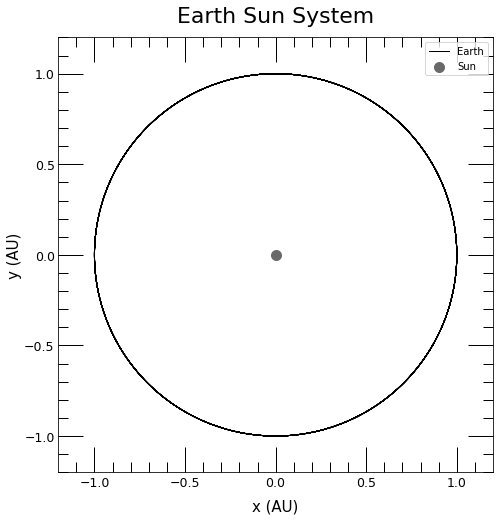

In [6]:
nsteps = 10000
dt = 10 * yr / nsteps
earth_sun_system.basic_topdown_plot(dt,nsteps,scheme="dkd",to_plot="xy",static_star=0,title="Earth Sun System",x_label="x (AU)",y_label="y (AU)",scale=AU,colors=["dimgrey","black"])

#### Plot distance plots for different dt

In [8]:
nsteps = 10000
dt = 10 * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 10000 and dt = 31556.9


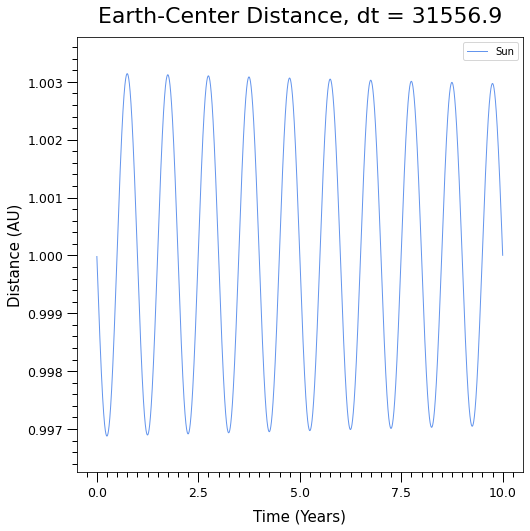

In [9]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Center Distance, dt = " + str(dt))

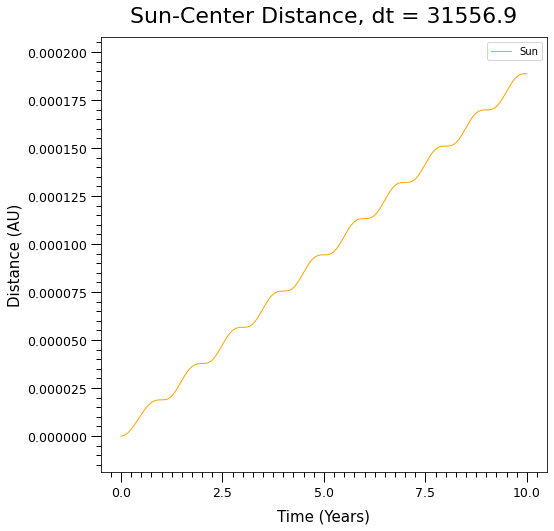

In [10]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Sun"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Sun-Center Distance, dt = " + str(dt))

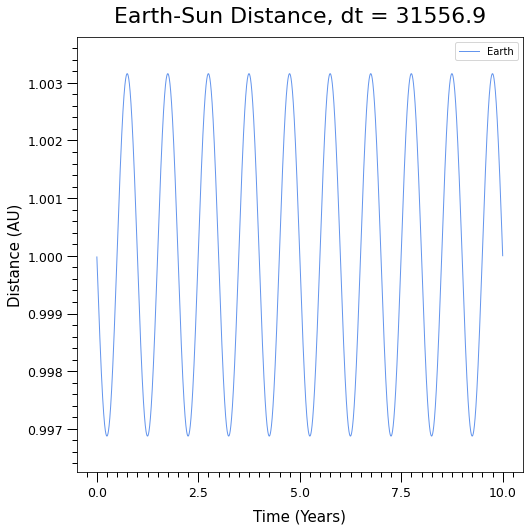

In [11]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Sun",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Sun Distance, dt = " + str(dt))

In [12]:
nsteps = 5000
dt = 10 * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 5000 and dt = 63113.8


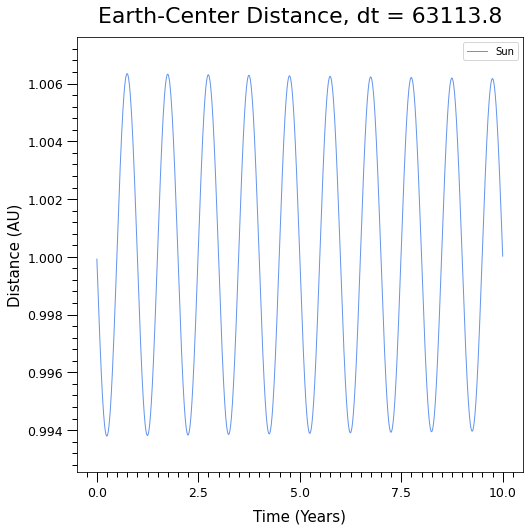

In [13]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Center Distance, dt = " + str(dt))

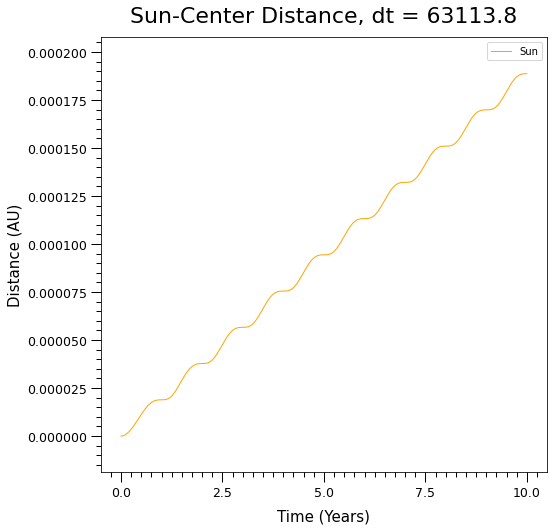

In [14]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Sun"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Sun-Center Distance, dt = " + str(dt))

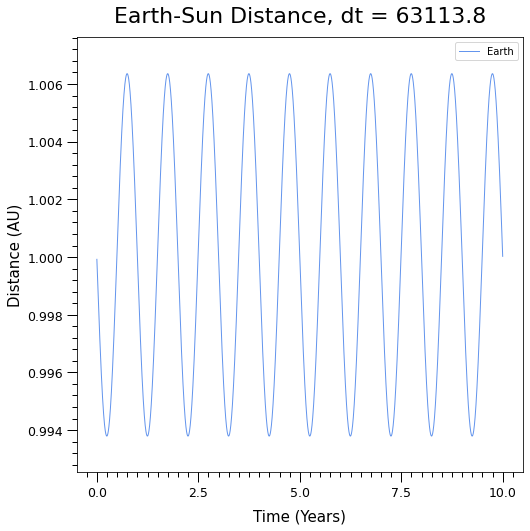

In [15]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Sun",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Sun Distance, dt = " + str(dt))

In [16]:
nsteps = 1000
dt = 10 * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 1000 and dt = 315569.0


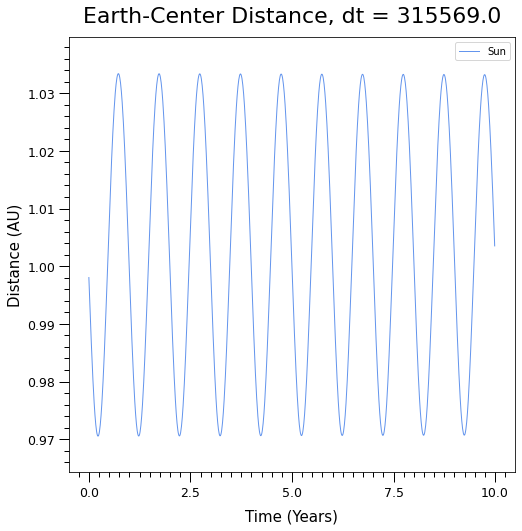

In [17]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Center Distance, dt = " + str(dt))

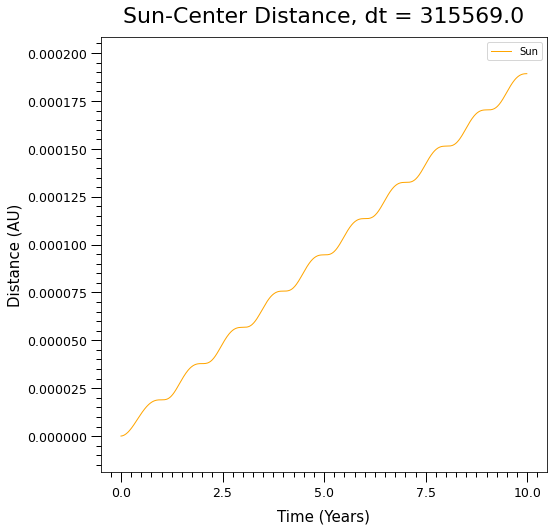

In [18]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Sun"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Sun-Center Distance, dt = " + str(dt))

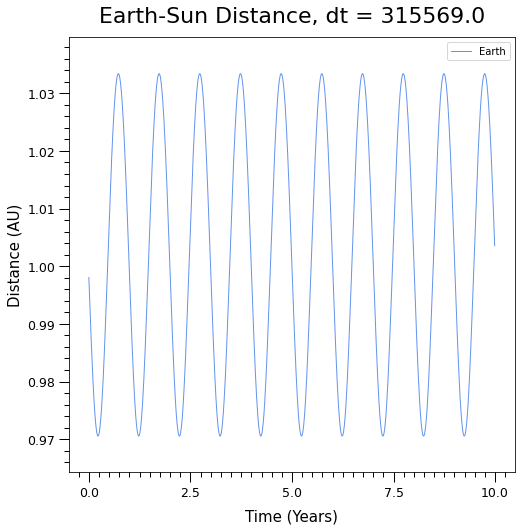

In [19]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Sun",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Sun Distance, dt = " + str(dt))

In [20]:
nsteps = 100
dt = 10 * yr / nsteps
print("Plotting E->C, S->C, E->S for nsteps =",nsteps,"and dt =",dt)

Plotting E->C, S->C, E->S for nsteps = 100 and dt = 3155690.0


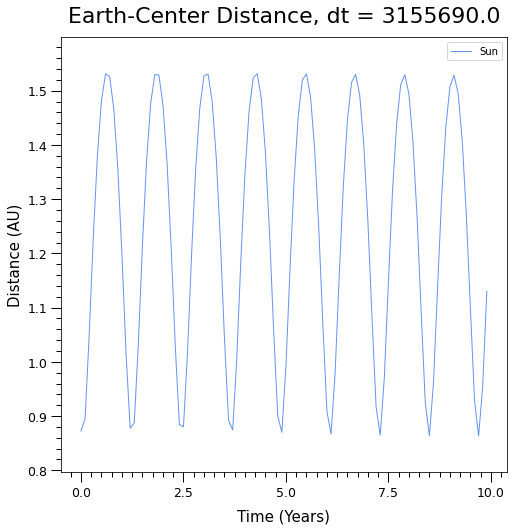

In [21]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Center Distance, dt = " + str(dt))

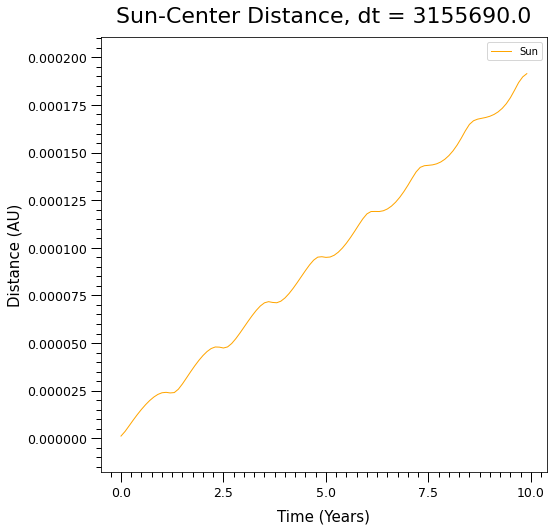

In [22]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Center",to_plot=["Sun"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Sun-Center Distance, dt = " + str(dt))

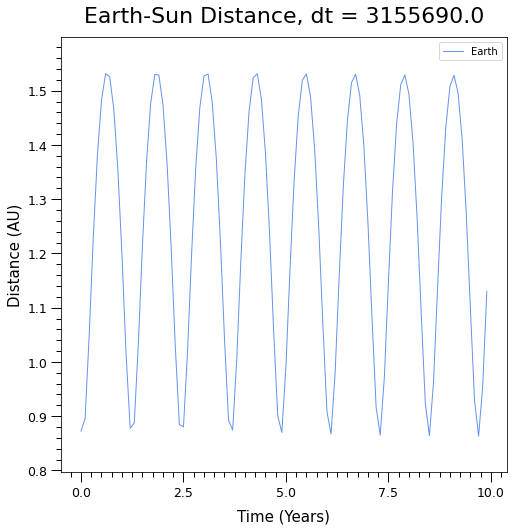

In [23]:
earth_sun_system.basic_d_t_plot(dt,nsteps,base_object="Sun",to_plot=["Earth"],distance_scale=AU,time_scale=yr,x_label="Time (Years)",y_label="Distance (AU)",title="Earth-Sun Distance, dt = " + str(dt))

### 2)

In [24]:
data_file = 'https://astro.uchicago.edu/~andrey/classes/a211/data/gj876.dat'
name = np.loadtxt(data_file, usecols=[0], unpack=True, dtype=str)
mp, xp, yp, zp, vxp, vyp, vzp = np.loadtxt(data_file, usecols=(1,2,3,4,5,6,7), unpack=True)

start_date = 2449680
end_date = 2453000

plot_date = 2449710
plot_length = 60

steps = int(13280 * 2)

x = np.column_stack((xp,yp,zp))
v = np.column_stack((vxp,vyp,vzp))

gj876 = simulation(x,v,mp,object_names = ["Star","Planet 1","Planet 2"])

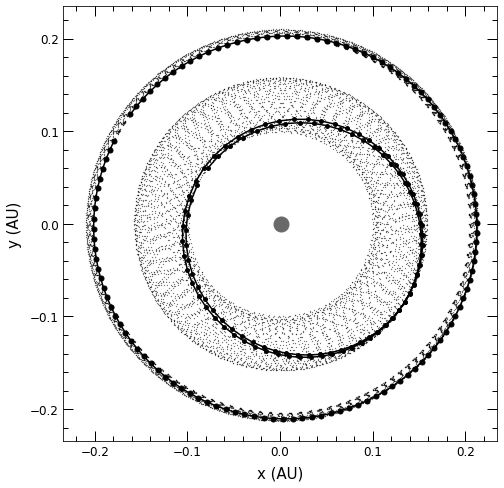

In [25]:
gj876.laughlin_topdown_plot(steps,start_date,end_date,plot_date,plot_length,scheme="dkd",star="Star",sizes=[15,25])

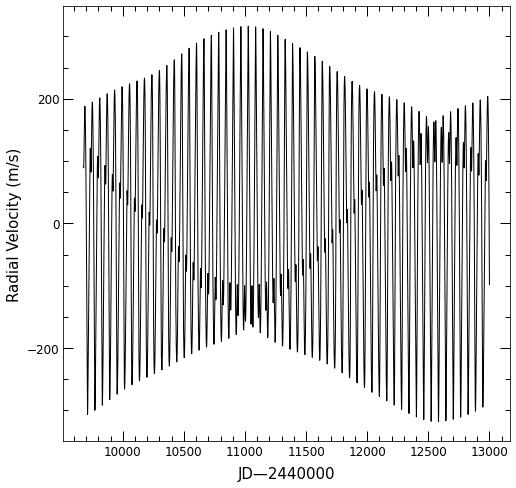

In [26]:
gj876.laughlin_velocity_time(steps,start_date,end_date,scheme = 'dkd',plot_offset = 2440000,component="y",flip=True)